In [5]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth unsloth_zoo  # Add unsloth_zoo explicitly
else:
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

In [4]:
# In Colab, run this cell before anything else
%env PYTHON_VERSION=3.10

env: PYTHON_VERSION=3.10


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Step 2: Load Dataset**

In [3]:
import pandas as pd
from datasets import Dataset
import random

In [13]:
# ============================================================
# SIMPLIFIED: Just load the raw text
# ============================================================
def create_dataset_from_text(txt_file_path):
    """
    Simply loads sentences - no manual tokenization needed!
    The model will learn to predict next tokens automatically.
    """
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]

    print(f"Loaded {len(sentences)} sentences")

    # Just create a DataFrame with the raw text
    df = pd.DataFrame({'text': sentences})
    return df

In [14]:
# Load and prepare dataset
df = create_dataset_from_text("/content/drive/MyDrive/WR_Project/cleaned-text.txt")  # Replace with your file path
print(f"Dataset has {len(df)} sentences")
print(df.head())

Loaded 204627 sentences
Dataset has 204627 sentences
                                                text
0  សាលារាជធានីថាមិនទាន់ទទួលបានលិខិតសុំធ្វើបាតុកម្...
1  ភ្នំពេញសាលារាជធានីភ្នំពេញនៅមិនទាន់ទទួលបានលិខិត...
2  នេះបើតាមលោកឡុងឌីម៉ង់អ្នកនាំពាក្យសាលារាជធានីភ្ន...
3  សូមជំរាបថានាថ្មីៗនេះក្រុមសម្ព័ន្ធយុវជនគណបក្សប្...
4  យប់នេះប៉ូលិសដាក់ប៉ុស្តិ៍រហូតដល់៧កន្លែងបងប្អូនស...


In [17]:
max_len = df["text"].str.len().max()
print(max_len)

700


In [18]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
print(f"Dataset size: {len(dataset)}")

Dataset size: 204627


In [19]:
# Split into train/val
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

In [7]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [21]:
# UNCHANGED: Model loading
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Instruct-2507",
    max_seq_length = 1024,  # Reduced from 2048 since max sentence is ~700 chars
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
)

==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [22]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 32,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)


Unsloth 2026.1.2 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [8]:
from unsloth.chat_templates import get_chat_template

In [10]:
tokenizer = get_chat_template(tokenizer, chat_template="qwen3-instruct")

NameError: name 'tokenizer' is not defined

In [25]:
# ============================================================
# SIMPLIFIED: Just wrap text in chat format
# ============================================================
def formatting_prompts_func(examples):
    """
    Wraps each sentence in chat format.
    Model learns to continue/complete the text.
    """
    texts = []
    for sentence in examples["text"]:
        # Simple format: user provides incomplete text, assistant completes it
        # We'll use the full sentence as training
        prompt = f"""<|im_start|>user\n{sentence}<|im_end|>\n<|im_start|>assistant\n{sentence}<|im_end|>"""
        texts.append(prompt)
    return {"text": texts}

In [26]:
# Apply formatting
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/184164 [00:00<?, ? examples/s]

Map:   0%|          | 0/20463 [00:00<?, ? examples/s]

In [9]:
from trl import SFTTrainer, SFTConfig

In [28]:
# UNCHANGED: Training configuration
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=SFTConfig(
        dataset_text_field="text",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=300,
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=3407,
        report_to="none",
        output_dir="output_dir",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/184164 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/20463 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


In [11]:
from unsloth.chat_templates import train_on_responses_only

In [30]:
trainer = train_on_responses_only(
    trainer,
    instruction_part="user\n",
    response_part="assistant\n",
)

Map (num_proc=6):   0%|          | 0/184164 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/20463 [00:00<?, ? examples/s]

In [31]:
# Train
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 184,164 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.185100
2,0.193400
3,0.191500
4,0.132500
5,0.081700
6,0.002000
7,0.000700
8,0.000600
9,0.000600
10,0.006100


In [12]:
# UNCHANGED: Plot losses
import matplotlib.pyplot as plt
import numpy as np

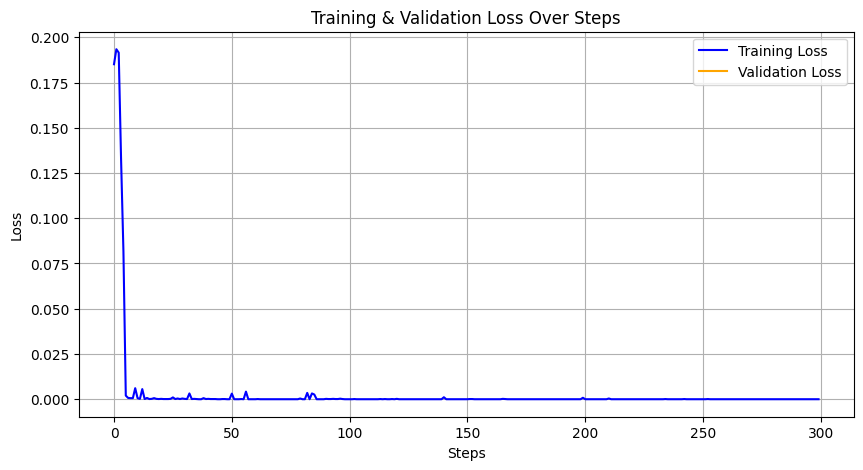

In [33]:
logs = trainer.state.log_history
train_losses = [log.get("loss", float('inf')) for log in logs if "loss" in log]
val_losses = [log.get("eval_loss", float('inf')) for log in logs if "eval_loss" in log]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Save model directly to Google Drive
model.save_pretrained("/content/drive/MyDrive/WR_Project/Qwen_nextword_model")
tokenizer.save_pretrained("/content/drive/MyDrive/WR_Project/Qwen_nextword_model")

('/content/drive/MyDrive/WR_Project/Qwen_nextword_model/tokenizer_config.json',
 '/content/drive/MyDrive/WR_Project/Qwen_nextword_model/special_tokens_map.json',
 '/content/drive/MyDrive/WR_Project/Qwen_nextword_model/chat_template.jinja',
 '/content/drive/MyDrive/WR_Project/Qwen_nextword_model/vocab.json',
 '/content/drive/MyDrive/WR_Project/Qwen_nextword_model/merges.txt',
 '/content/drive/MyDrive/WR_Project/Qwen_nextword_model/added_tokens.json',
 '/content/drive/MyDrive/WR_Project/Qwen_nextword_model/tokenizer.json')

In [13]:
# ============================================================
# Inference function for keyboard-style prediction
# ============================================================
from unsloth import FastLanguageModel
import torch

In [14]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/WR_Project/Qwen_nextword_model",
    max_seq_length = 1024,  # Match training config
    load_in_4bit = True,
    full_finetuning = False,
)

==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

Unsloth 2026.1.2 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [39]:
def predict_next(context, max_predictions=20):
    """
    Predicts next text given context (like keyboard prediction).

    Args:
        context: The text typed so far
        max_predictions: Maximum characters/tokens to predict

    Returns:
        The predicted continuation
    """
    prompt = f"""<|im_start|>user\n{context}<|im_end|>\n<|im_start|>assistant\n"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_predictions,
        temperature=0.7,
        top_p=0.9,
        top_k=50,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract assistant response
    if "<|im_start|>assistant" in generated_text:
        prediction = generated_text.split("<|im_start|>assistant")[1].split("<|im_end|>")[0].strip()
    else:
        prediction = generated_text.strip()

    return prediction

In [16]:
import torch
import numpy as np
from tqdm import tqdm
from unsloth import FastLanguageModel

In [17]:
# ============================================================
# Load Model
# ============================================================
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/WR_Project/Qwen_nextword_model",
    max_seq_length = 1024,
    load_in_4bit = True,
    full_finetuning = False,
)
FastLanguageModel.for_inference(model)  # Enable inference mode

==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 2560, padding_idx=151654)
        (layers): ModuleList(
          (0): Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2560, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
      

In [18]:
# ============================================================
# 1. PERPLEXITY CALCULATION
# ============================================================
def calculate_perplexity(model, tokenizer, test_sentences, max_samples=100):
    """
    Calculate perplexity on test sentences.
    Lower perplexity = better model.
    """
    model.eval()
    total_loss = 0
    total_tokens = 0

    test_sentences = test_sentences[:max_samples]

    with torch.no_grad():
        for sentence in tqdm(test_sentences, desc="Computing perplexity"):
            # Tokenize
            inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=1024).to("cuda")

            # Get model outputs
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss

            # Accumulate
            total_loss += loss.item() * inputs["input_ids"].size(1)
            total_tokens += inputs["input_ids"].size(1)

    # Perplexity = exp(average loss)
    perplexity = np.exp(total_loss / total_tokens)
    return perplexity

In [19]:
# ============================================================
# 2. TOP-K ACCURACY
# ============================================================
def calculate_topk_accuracy(model, tokenizer, test_sentences, k=5, max_samples=100):
    """
    Calculate top-k accuracy for next token prediction.

    For each position in the sentence, check if the actual next token
    is in the top-k predicted tokens.
    """
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    test_sentences = test_sentences[:max_samples]

    with torch.no_grad():
        for sentence in tqdm(test_sentences, desc=f"Computing top-{k} accuracy"):
            # Tokenize
            tokens = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=1024).to("cuda")
            input_ids = tokens["input_ids"][0]

            # Skip very short sequences
            if len(input_ids) < 5:
                continue

            # For each position (except last), predict next token
            for i in range(len(input_ids) - 1):
                context = input_ids[:i+1].unsqueeze(0)

                # Get logits for next token
                outputs = model(context)
                logits = outputs.logits[0, -1, :]  # Last position logits

                # Get top-k predictions
                top_k_tokens = torch.topk(logits, k).indices

                # Check if actual next token is in top-k
                actual_next_token = input_ids[i+1]
                if actual_next_token in top_k_tokens:
                    correct_predictions += 1
                total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

In [20]:
# ============================================================
# 3. FIXED PREDICTION FUNCTION
# ============================================================
def predict_next_word(context, num_predictions=3, max_new_tokens=10):
    """
    Predict next word(s) given context - FIXED VERSION.
    Returns multiple predictions with their probabilities.

    Args:
        context: Input text
        num_predictions: Number of alternative predictions to return
        max_new_tokens: Max tokens to generate

    Returns:
        List of (prediction, probability) tuples
    """
    model.eval()

    # Tokenize input
    inputs = tokenizer(context, return_tensors="pt", truncation=True, max_length=1024).to("cuda")

    with torch.no_grad():
        # Get logits for next token
        outputs = model(**inputs)
        next_token_logits = outputs.logits[0, -1, :]

        # Get probabilities
        probs = torch.softmax(next_token_logits, dim=-1)

        # Get top-k tokens and their probabilities
        top_probs, top_indices = torch.topk(probs, num_predictions)

        predictions = []
        for prob, idx in zip(top_probs, top_indices):
            token = tokenizer.decode([idx], skip_special_tokens=True)
            predictions.append((token, prob.item()))

    return predictions

def predict_continuation(context, max_new_tokens=20, temperature=0.7):
    """
    Generate continuation of text (like autocomplete).

    Args:
        context: Input text
        max_new_tokens: How many tokens to generate
        temperature: Sampling temperature (lower = more deterministic)

    Returns:
        Generated continuation
    """
    model.eval()

    # Tokenize
    inputs = tokenizer(context, return_tensors="pt", truncation=True, max_length=1024).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=0.9,
            top_k=50,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id else tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decode only the new tokens (not the input)
    generated_text = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return generated_text

In [21]:

# ============================================================
# 4. RUN EVALUATION
# ============================================================
# Load test data
import pandas as pd
df_test = pd.read_csv("/content/drive/MyDrive/WR_Project/cleaned-text.txt", header=None, names=['text'])
test_sentences = df_test['text'].tolist()

print("="*60)
print("EVALUATING MODEL")
print("="*60)

# Perplexity
print("\n1. Computing Perplexity...")
ppl = calculate_perplexity(model, tokenizer, test_sentences, max_samples=50)
print(f"Perplexity: {ppl:.2f}")
print(f"  → Lower is better. Good models: 10-50, Excellent: <10")

# Top-K Accuracy
print("\n2. Computing Top-5 Accuracy...")
top5_acc = calculate_topk_accuracy(model, tokenizer, test_sentences, k=5, max_samples=50)
print(f"Top-5 Accuracy: {top5_acc*100:.2f}%")

print("\n3. Computing Top-10 Accuracy...")
top10_acc = calculate_topk_accuracy(model, tokenizer, test_sentences, k=10, max_samples=50)
print(f"Top-10 Accuracy: {top10_acc*100:.2f}%")

EVALUATING MODEL

1. Computing Perplexity...


Computing perplexity: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Perplexity: 6.34
  → Lower is better. Good models: 10-50, Excellent: <10

2. Computing Top-5 Accuracy...


Computing top-5 accuracy: 100%|██████████| 50/50 [36:13<00:00, 43.47s/it]


Top-5 Accuracy: 79.38%

3. Computing Top-10 Accuracy...


Computing top-10 accuracy: 100%|██████████| 50/50 [35:44<00:00, 42.90s/it]

Top-10 Accuracy: 89.88%


In [15]:
# ============================================================
# 6. COMPARE WITH N-GRAM BASELINE
# ============================================================
print("\n" + "="*60)
print("COMPARISON GUIDELINES")
print("="*60)
print("""
If your N-gram model performs better, the issue might be:

1. TRAINING DATA:
   - Not enough training steps (only 300 steps)
   - Need more data or more epochs

2. TRAINING FORMAT:
   - Current format might not be optimal for next-word prediction
   - Consider removing chat template for pure language modeling

3. MODEL SIZE:
   - 4B parameters might be overkill for simple next-word prediction
   - Consider smaller model or more focused training

SUGGESTIONS:
- Increase max_steps from 300 to 1000-2000
- Train longer on your specific domain
- Try different learning rates
- Compare perplexity: Your model vs N-gram
""")


TESTING PREDICTIONS

--- Next Token Predictions (Top 3) ---

Input: សាលារាជធានីថាមិនទាន់ទទួលបា


NameError: name 'predict_next_word' is not defined

In [ ]:


# ============================================================
# 5. TEST PREDICTIONS
# ============================================================
print("\n" + "="*60)
print("TESTING PREDICTIONS")
print("="*60)

test_contexts = [
    "សាលារាជធានីថាមិនទាន់ទទួលបា",
    "ភ្នំពេញសាលារាជធានីភ្នំពេញនៅមិនទាន់",
    "នេះបើតាមលោក",
]

print("\n--- Next Token Predictions (Top 3) ---")
for context in test_contexts:
    print(f"\nInput: {context}")
    predictions = predict_next_word(context, num_predictions=3)
    for i, (token, prob) in enumerate(predictions, 1):
        print(f"  {i}. '{token}' (prob: {prob:.4f})")

print("\n--- Text Continuation ---")
for context in test_contexts:
    print(f"\nInput: {context}")
    continuation = predict_continuation(context, max_new_tokens=15)
    print(f"Output: {continuation}")